## Fetch Bitcoin Data

In [1]:
# import libraries
import math
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import datetime as dt
from binance import Client
import csv

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Verifica si el archivo existe y elimínalo
import os
archivo_excel = "BTCUSDT.csv"
if os.path.exists(archivo_excel):
    os.remove(archivo_excel)


In [2]:
# create client object from binance library
client = Client(None, None)

In [3]:
# defining the function that fetch the historical data of the wanted coin
def getdata(symbol, period, start, end):
    """
    This function gives us the historical candle data of the desired coin
    :param symbol: coin name that you want to get data
    :param period: time period of candles
    :param start: starting date of candles data
    :param end: end date of candles data
    :return: candles data
    """
    candles = client.get_historical_klines(symbol, period, start, end)
    return candles

In [4]:
# defining the function that make csv file of the historical data of the wanted coin
def make_csv(symbol, candles):
    """
    This function makes csv file of desired coin with defined properties
    :param symbol: coin name that you want to make csv file
    :param candles: historical data of the desired coin
    :return: historical data in csv file
    """
    csvfile = open(symbol + ".csv", "a", newline="")
    cursor = csv.writer(csvfile)
    for i in candles:
        cursor.writerow(i)
    csvfile.close()

In [5]:
# defining the function that make csv files of the historical data of the wanted multiple coin
def multiple_csv(symbols, interval, start, end):
    """
    This function makes csv file for each coin in symbols parameter with defined properties
    :param symbols: list of multiple coin names that you want to make csv file
    :param interval: time period of candles (default: client.KLINE_INTERVAL_1DAY you can change the interval)
    :param start: starting date of candles data
    :param end: end date of candles data
    :return: historical data of multiple coin in csv files
    """
    for i in symbols:
        make_csv(i, getdata(i, interval, str(start), str(end)))
        print(i, "csv file is ready.")

In [6]:
# defining function the that turn the timestamp to the date 
def calculate_time(timestamp):
    """
    This function turns the timestamp to the date
    :param timestamp: given timestamp
    :return: date according to given timestamp
    """
    return dt.fromtimestamp(timestamp/1000)

In [7]:
# get Bitcoin historical data and make csv
multiple_csv(["BTCUSDT"], client.KLINE_INTERVAL_1HOUR, "1 January 2010", "31 January 2025")

BTCUSDT csv file is ready.


In [8]:
# read Bitcoin histroical data as dataframe with column names
headers = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]
data = pd.read_csv("BTCUSDT.csv", names=headers)
data.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,QAV,NAT,TBBAV,TBQAV,Ignore
0,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,150952.477943,0
1,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,92608.279728,0
2,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,20795.317224,0
3,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443249,1502956799999,19241.058300,25,2.602292,11291.347015,0
4,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.503586,28,0.814655,3552.746817,0


In [9]:
# Turn "Open Time" and "Close Time" columns to Date
open_date = []
for i in data["Open Time"]:
    open_date.append(calculate_time(i))
data["Open Time"] = open_date

close_date = []
for i in data["Close Time"]:
    close_date.append(calculate_time(i))
data["Close Time"] = close_date
data

,Open Time,Open,High,Low,Close,Volume,Close Time,QAV,NAT,TBBAV,TBQAV,Ignore
0,2017-08-16 23:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,2017-08-16 23:59:59.999,2.023661e+05,171,35.160503,1.509525e+05,0
1,2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,2017-08-17 00:59:59.999,1.003048e+05,102,21.448071,9.260828e+04,0
2,2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,2017-08-17 01:59:59.999,3.128231e+04,36,4.802861,2.079532e+04,0
3,2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,2017-08-17 02:59:59.999,1.924106e+04,25,2.602292,1.129135e+04,0
4,2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,2017-08-17 03:59:59.999,4.239504e+03,28,0.814655,3.552747e+03,0
...,...,...,...,...,...,...,...,...,...,...,...,...
65240,2025-01-30 15:00:00,105711.28,105821.62,104815.82,104907.15,1118.427530,2025-01-30 15:59:59.999,1.178239e+08,267107,592.746900,6.244692e+07,0
65241,2025-01-30 16:00:00,104907.10,105217.17,104805.15,105048.89,488.853350,2025-01-30 16:59:59.999,5.134625e+07,134442,258.134440,2.711341e+07,0
65242,2025-01-30 17:00:00,105048.89,105351.29,104962.11,105094.56,279.525670,2025-01-30 17:59:59.999,2.938796e+07,62704,163.034310,1.714230e+07,0
65243,2025-01-30 18:00:00,105094.57,105254.00,104693.82,104722.94,395.499620,2025-01-30 18:59:59.999,4.152436e+07,75973,157.022000,1.649169e+07,0


## Visualize the Bitcoin Data

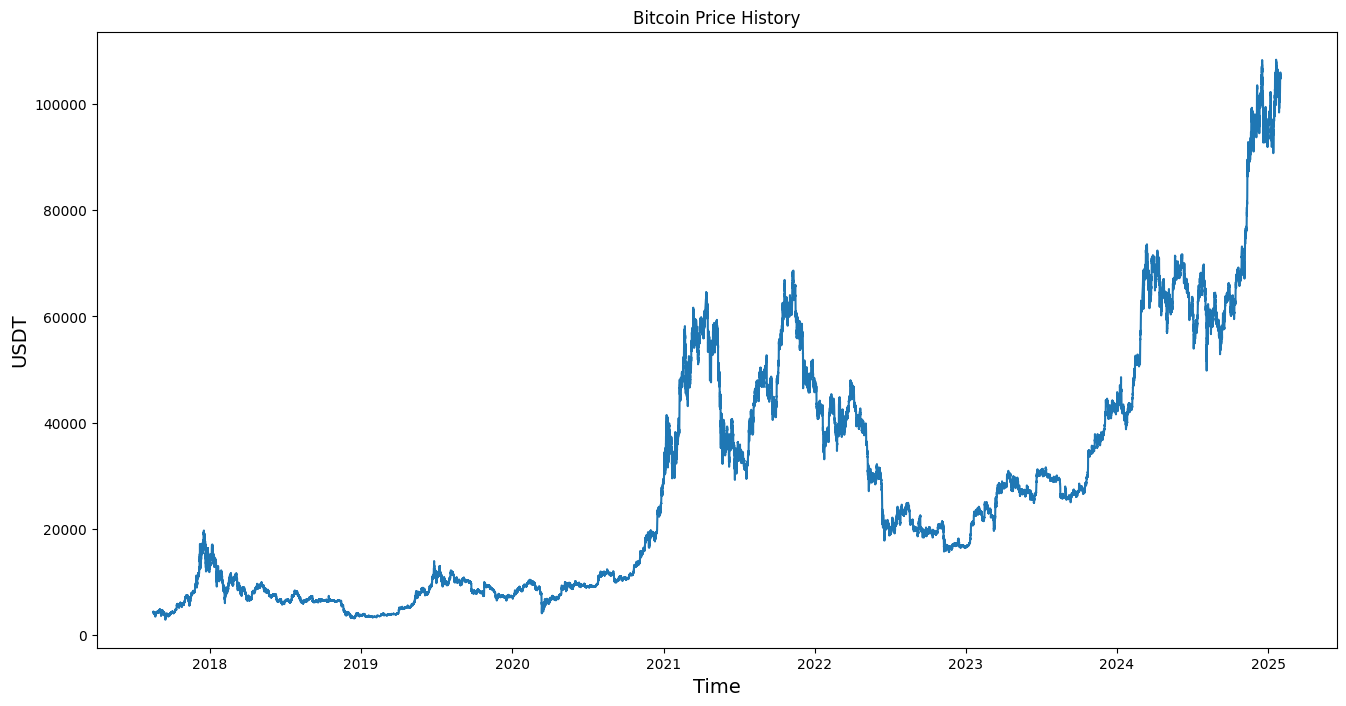

In [10]:
# Visualize the close price history
plt.figure(figsize=(16, 8))
plt.title("Bitcoin Price History")
plt.plot(data["Close Time"], data["Close"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

## Create Train and Test Data

In [11]:
# Create new data with only the "Close" column
close = data.filter(["Close"])
# Convert the dataframe to a np array
close_array = close.values
# See the train data len
train_close_len = math.ceil(len(close_array) * 0.8)
train_close_len

52196

In [12]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_array)
scaled_data

array([[0.01318612],
       [0.01324769],
       [0.01333336],
       ...,
       [0.9693983 ],
       [0.96587253],
       [0.96753807]])

In [13]:
# Create the training dataset
train_data = scaled_data[0 : train_close_len, :]
# Create X_train and y_train
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(X_train)
        print(y_train)

[array([0.01318612, 0.01324769, 0.01333336, 0.01357663, 0.01367814,
       0.01446855, 0.01462035, 0.01431011, 0.01415546, 0.01461087,
       0.01472301, 0.01359892, 0.01361638, 0.01300025, 0.01269409,
       0.01334171, 0.01354579, 0.01342065, 0.01345148, 0.01296079,
       0.01297454, 0.01256715, 0.01279485, 0.01303014, 0.01298773,
       0.01323099, 0.01290747, 0.01310471, 0.01293849, 0.01314171,
       0.01363659, 0.01348479, 0.01340319, 0.01303678, 0.01271715,
       0.01250358, 0.01263119, 0.01209049, 0.01137   , 0.01154904,
       0.01045635, 0.01002543, 0.01133528, 0.01128424, 0.01180719,
       0.01166526, 0.01173983, 0.01157057, 0.01090369, 0.01098661,
       0.0101315 , 0.01057362, 0.01024658, 0.01090312, 0.01026157,
       0.0098538 , 0.01115739, 0.01063405, 0.01065844, 0.00999089])]
[np.float64(0.010256068703705969)]


In [14]:
#  make X_train and y_train np array
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(52136, 60, 1)

In [16]:
# create the testing dataset
test_data = scaled_data[train_close_len - 60 : , :]
# create X_test and y_test
X_test = []
y_test = data.iloc[train_close_len : , :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

In [17]:
# convert the test data to a np array and reshape the test data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Build a LSTM Model

In [18]:
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))


model.add(LSTM(units=256, activation='relu', return_sequences=False))


model.add(Dense(units=1))

In [19]:
# compile the LSTM model
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [20]:
# train the LSTM model
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
522/522 ━━━━━━━━━━━━━━━━━━━━ 227s 423ms/step - loss: 0.0018 - mae: 0.0145
Epoch 2/3
522/522 ━━━━━━━━━━━━━━━━━━━━ 304s 584ms/step - loss: 2.2494e-05 - mae: 0.0029
Epoch 3/3
522/522 ━━━━━━━━━━━━━━━━━━━━ 417s 801ms/step - loss: 2.1987e-05 - mae: 0.0029


In [21]:
# predict with LSTM model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

408/408 ━━━━━━━━━━━━━━━━━━━━ 86s 210ms/step


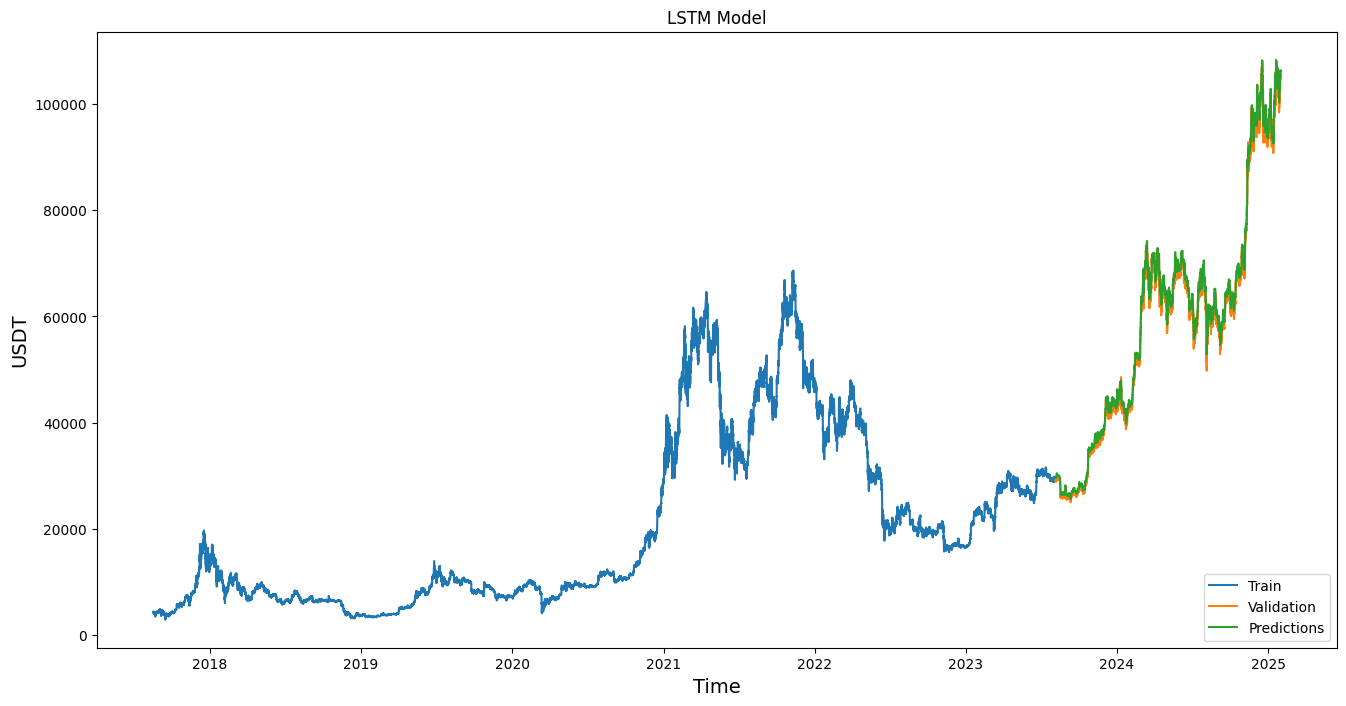

In [22]:
# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][:train_close_len], train["Close"])
plt.plot(data["Close Time"][train_close_len:], valid[["Close", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

## Build a Optimized LSTM Model

In [23]:
# change the parameters of first LSTM model and build the Optimized LSTM Model
optimized_model = Sequential()

optimized_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

optimized_model.add(LSTM(100, return_sequences=False))

optimized_model.add(Dense(50))

optimized_model.add(Dense(1))

In [24]:
# compile the model
optimized_model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [25]:
# train the optimized model
optimized_model.fit(X_train, y_train, 
          batch_size=10, 
          epochs=3, 
          verbose=1)

Epoch 1/3
5214/5214 ━━━━━━━━━━━━━━━━━━━━ 136s 25ms/step - loss: 3.3319e-04 - mae: 0.0058
Epoch 2/3
5214/5214 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - loss: 1.6928e-05 - mae: 0.0029
Epoch 3/3
5214/5214 ━━━━━━━━━━━━━━━━━━━━ 98s 17ms/step - loss: 1.1698e-05 - mae: 0.0024


In [26]:
# Predict with optimized LSTM model
o_predictions = optimized_model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [47]:
optimized_model.save_weights("optimized_model.weights.h5")

In [48]:
optimized_model.load_weights("optimized_model.weights.h5")

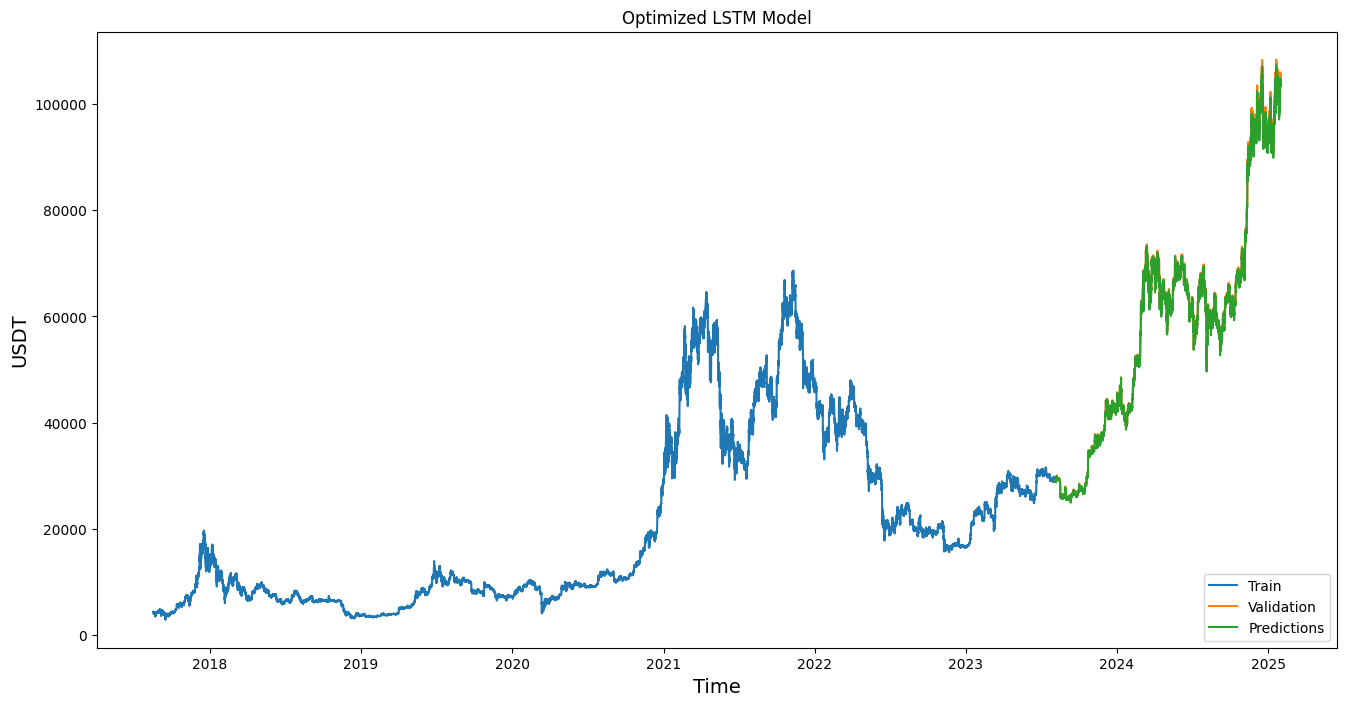

In [49]:
# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][:train_close_len], train["Close"])
plt.plot(data["Close Time"][train_close_len:], valid[["Close", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

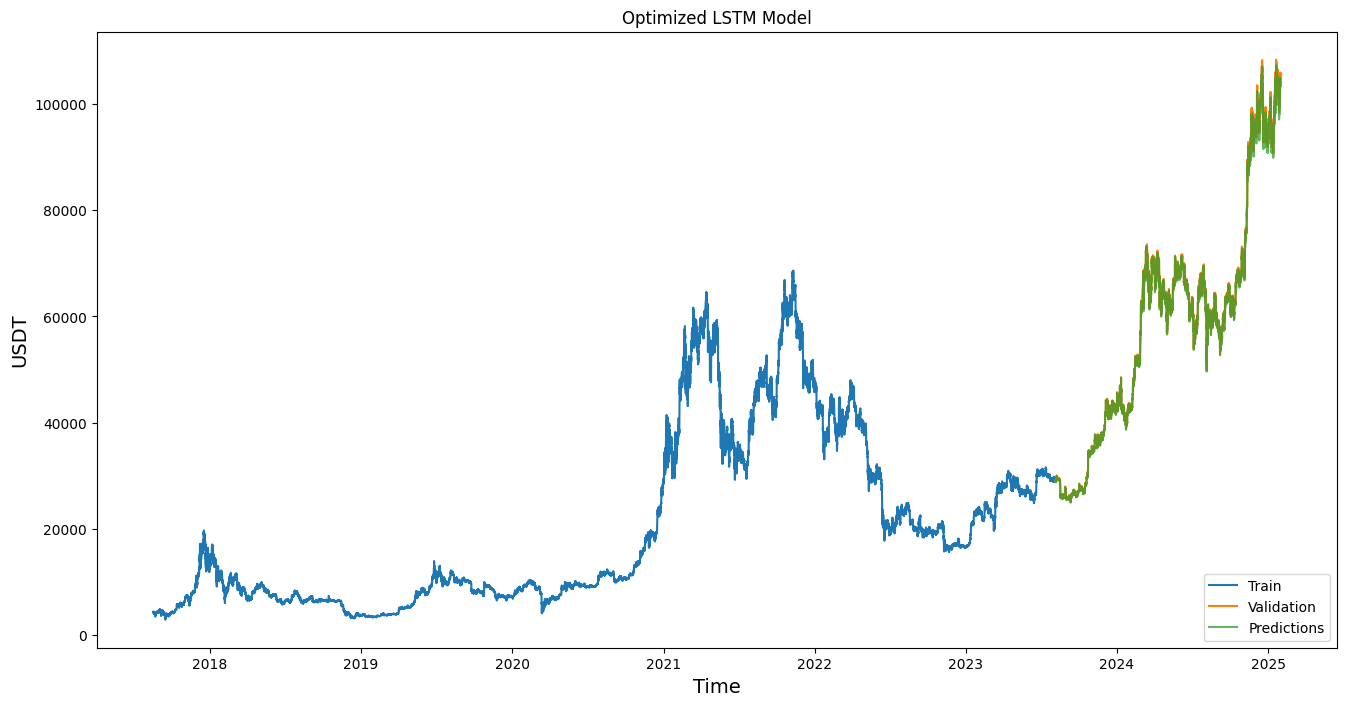

In [42]:
# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][:train_close_len], train["Close"])
plt.plot(data["Close Time"][train_close_len:], valid[["Close"]])
plt.plot(data["Close Time"][train_close_len:], valid[["Predictions"]], alpha=0.75)
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

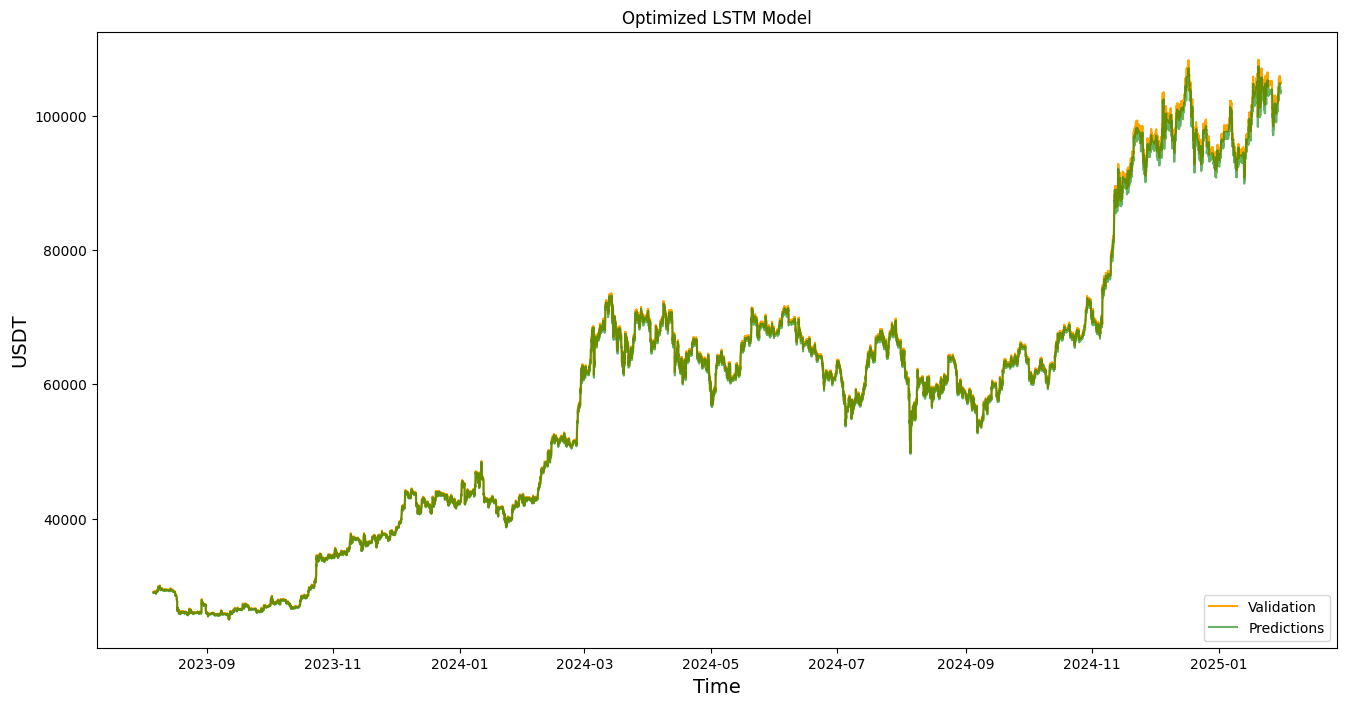

In [45]:
# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(data["Close Time"][train_close_len:], valid[["Close"]], color="orange")
plt.plot(data["Close Time"][train_close_len:], valid[["Predictions"]], alpha=0.6, color="green")
plt.legend(["Validation", "Predictions"], loc="lower right")
plt.show()